In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import plotpy
from prophet import Prophet

In [70]:
header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
df = pd.read_csv('./Data/BTCUSDT-trades-2023-05-26.csv',header=0 , names = header)
df.head()

,trade_id,price,quantity,order_id,timestamp,is_buyer_maker
0,3751246457,26461.7,0.041,1084.9297,1685059200171,True
1,3751246458,26461.7,0.359,9499.7503,1685059200171,True
2,3751246459,26461.8,0.003,79.3854,1685059200251,False
3,3751246460,26461.8,0.002,52.9236,1685059200371,False
4,3751246461,26461.8,0.008,211.6944,1685059200407,False


In [71]:
def closed_time_series(df, time_interval):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    df['buy_quantity'] = np.where(df['is_buyer_maker'], df['quantity'], 0)
    df['sell_quantity'] = np.where(df['is_buyer_maker'], 0, df['quantity'])
    df = df.resample(str(time_interval)+'S').agg({'price':'last', 'quantity':'sum', 'buy_quantity':'sum', 'sell_quantity':'sum'})
    df['return'] = df['price'].diff() / 0.1
    df = df.dropna()
    return df

In [72]:
df_closed = closed_time_series(df,10)

In [73]:
df_closed['ofi'] = df_closed['buy_quantity'] - df_closed['sell_quantity']

In [74]:
df_closed

,price,quantity,buy_quantity,sell_quantity,return,ofi
timestamp,,,,,,
2023-05-26 00:00:10,26465.9,14.788,9.252,5.536,0.0,3.716
2023-05-26 00:00:20,26473.0,80.669,2.213,78.456,71.0,-76.243
2023-05-26 00:00:30,26473.0,14.717,0.648,14.069,0.0,-13.421
2023-05-26 00:00:40,26473.0,12.344,2.306,10.038,0.0,-7.732
2023-05-26 00:00:50,26473.0,8.482,5.015,3.467,0.0,1.548
...,...,...,...,...,...,...
2023-05-26 23:59:10,26693.3,3.439,2.308,1.131,0.0,1.177
2023-05-26 23:59:20,26693.2,4.463,0.178,4.285,-1.0,-4.107
2023-05-26 23:59:30,26692.4,7.818,5.737,2.081,-8.0,3.656


01:59:24 - cmdstanpy - INFO - Chain [1] start processing
01:59:24 - cmdstanpy - INFO - Chain [1] done processing


                      ds       yhat  yhat_lower  yhat_upper
0    2023-05-26 00:00:10  -1.417696  -51.960619   47.858202
1    2023-05-26 00:00:20  57.153867   10.713699  106.397066
2    2023-05-26 00:00:30  11.136097  -33.485343   57.595091
3    2023-05-26 00:00:40   6.969150  -43.109734   54.765412
4    2023-05-26 00:00:50   0.171739  -45.040079   52.237532
...                  ...        ...         ...         ...
1095 2023-05-26 04:22:40   0.965809  -47.101016   51.392504
1096 2023-05-26 04:23:40   0.963196  -47.737593   46.645735
1097 2023-05-26 04:24:40   0.960583  -46.793499   50.321960
1098 2023-05-26 04:25:40   0.957970  -44.306679   49.088698
1099 2023-05-26 04:26:40   0.955357  -48.048699   52.828048

[1100 rows x 4 columns]


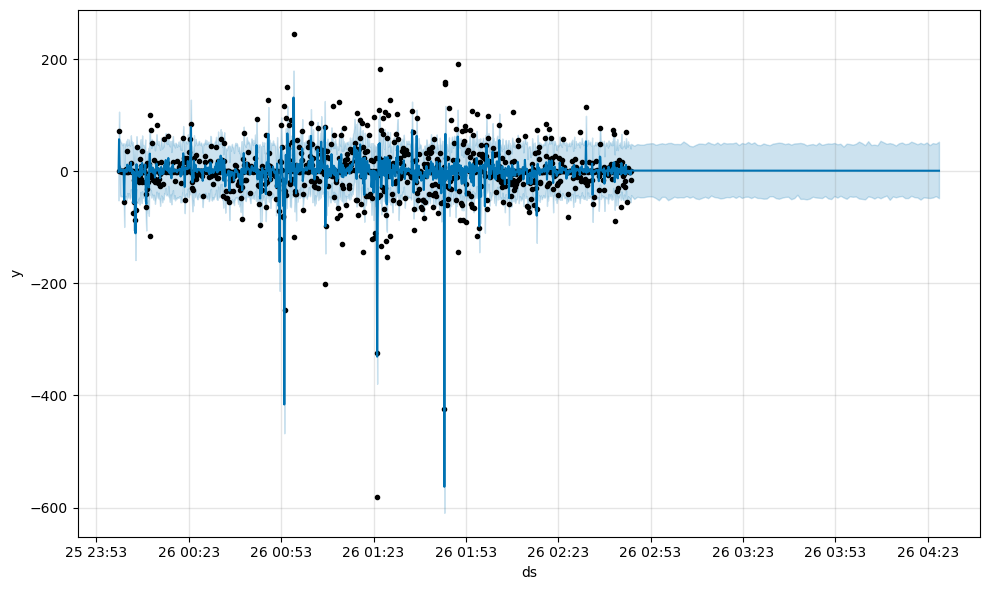

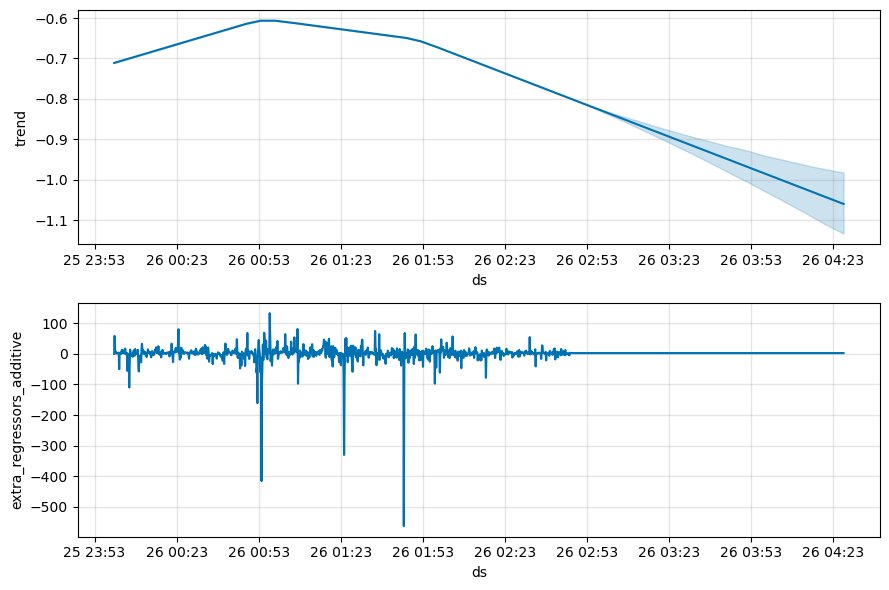

In [75]:
# 1. 데이터 준비
df_closed_2 = df_closed
df_closed_2 = df_closed_2.reset_index()  # 인덱스 초기화
df_closed_2 = df_closed_2[:1000]
df_closed_2['timestamp'] = pd.to_datetime(df_closed_2['timestamp'], unit='ms')  # timestamp를 datetime으로 변환

# Prophet에 맞는 데이터 구성
prophet_df = df_closed_2[['timestamp', 'price','return','quantity', 'buy_quantity', 'sell_quantity', 'ofi']].rename(
    columns={'timestamp': 'ds', 'return': 'y'}
)

# NaN 값 처리 (Prophet은 NaN 허용하지 않음)
prophet_df = prophet_df.fillna(0)

# 2. Prophet 모델 생성
model = Prophet()
# model.add_regressor('quantity')
# model.add_regressor('buy_quantity')
# model.add_regressor('sell_quantity')
model.add_regressor('ofi')

# 3. 모델 학습
model.fit(prophet_df)

# 4. 미래 데이터 생성
future = model.make_future_dataframe(periods=100, freq='T')  # 5분 예측
# future 데이터프레임에 추가 feature 추가
future = future.merge(
    prophet_df[['ds', 'quantity', 'buy_quantity', 'sell_quantity', 'ofi']],
    on='ds',
    how='left'
).fillna(0)  # NaN 값은 0으로 채움

# 5. 예측
forecast = model.predict(future)

# 6. 결과 확인
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# 7. 결과 시각화
# 전체 예측 플롯
model.plot(forecast)
plt.show()

# 트렌드 및 feature 영향 확인
model.plot_components(forecast)
plt.show()
